# Import manual segmentation results into starfish

Sometimes, automated methods just don't work. We know of at least two formats in use by our users and should write some methods to enable them to use their manual segmented data in starfish: 

* `GeoJSON`
* ImageJ `ROIset`
* ImageJ mask images

ImageJ masks can be created with the [Segmentation Editor](https://imagej.net/Segmentation_Editor) in FIJI. To demonstrate, this example will dump a MERFISH image that can be loaded into FIJI. 

It can be reached through `Plugins > Segmentation > Segmentation Editor`

In [1]:
%gui qt5

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, draw
import scipy.ndimage as ndi

import starfish
import starfish.data
from starfish.image import Filter
from starfish.types import Axes, Coordinates, Clip

# set figure DPI for screen viewing
matplotlib.rcParams["figure.dpi"] = 150

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.11.1. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [3]:
merfish = starfish.data.MERFISH()
merfish

<starfish.Experiment (FOVs=496)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_002: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
fov_003: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 2, r: 8, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 1, x: 2048, y: 2048)>
  ...,
}

In [4]:
def load_data(fov: str):
    fov = merfish[fov]
    dapi = fov.get_image("nuclei")
    primary = fov.get_image("primary")
    
    # clip outliers
    clip = Filter.Clip(p_max=99.9, expand_dynamic_range=True)
    clipped_primary = clip.run(primary)
    clipped_dapi = clip.run(dapi)
    
    # max proj then combine the two images
    mp = Filter.MaxProject({Axes.CH, Axes.ROUND, Axes.ZPLANE})
    projected = mp.run(clipped_primary)
    
    # combine images
    combined = np.maximum(primary.xarray.values.squeeze(), projected.xarray.values.squeeze())
    
    return dapi, combined

dapi, combined_image = load_data("fov_000")

100%|██████████| 1/1 [00:00<00:00, 140.29it/s]


Dump the result to tiff for segmentation.

In [5]:
io.imsave("fov_000.tiff", combined_image)

# Creating masks with Segmentation Manager
Note: when I segmented this thing, it saved as a tiff image, so we should be able to load that, too. Maybe by delegating to imageio. 

Segmentation workflow: 
- `Plugins > Segmentation > Segmentation Editor`
- Click "polygon selection" (third button from left on GUI)
- Create a polygon, then click the "+" button to finalize it. 
- Repeat until segmented
- Save the resulting mask (I saved as tiff)

When we fix the IO, this will be much easier. 

In [47]:
fiji_masks = io.imread("./fov_000.labels.tif")

In [48]:
# this thing was saved and loaded as an rgb image. :|
# FIJI is very flexible, we should expect all kinds of weird image formats. Probably we should not attempt
# IO on label images, just expect users to load them. 
import skimage
fiji_masks_gray = skimage.color.rgb2gray(fiji_masks)

In [49]:
mask = fiji_masks_gray.astype(bool)

In [50]:
# TODO: we really need to allow users to pass coordinates around (that needs to be a top-level item! 
#  If this works already, our type system needs to be clearer about what can be passed. 

label_image = ndi.label(mask)[0]

physical_ticks={
    starfish.types.Coordinates.X: dapi.xarray.coords[starfish.types.Coordinates.X.value],
    starfish.types.Coordinates.Y: dapi.xarray.coords[starfish.types.Coordinates.Y.value]
}
masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
    label_image, physical_ticks=physical_ticks
)

In [51]:
%gui qt5
starfish.display(dapi, masks=masks)

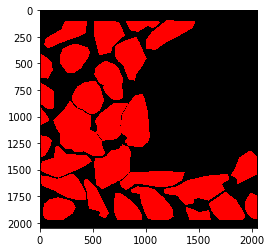

In [12]:
plt.imshow(label_image)

# Creating polygons with ROI Manager
Might want to work in the [ROImanager](http://imagej.net/docs/guide/146-30.html#fig:The-ROI-Manager) for ROIsets. 

Segmentation workflow: 
- Tools > ROI Manager
- Click "polygon selection" (third button from left on GUI)
- Create a polygon, then click the "+" button to finalize it. 
- Repeat until segmented
- Click "more >>>"
- Click "save" 
- Save the ROISet. 

In [20]:
from skimage import draw
from read_roi import read_roi_zip

roi_set = read_roi_zip("./RoiSet.zip")

In [21]:
# stolen from skimage, but made more efficient for drawing multiple polygons on the same mask
def polygons2mask(shape, polygons):
    mask = np.zeros(shape, dtype=np.bool)
    for polygon in polygons:
        polygon = np.asarray(polygon)
        vertex_row_coords, vertex_col_coords = polygon.T
        fill_row_coords, fill_col_coords = draw.polygon(
            vertex_row_coords, vertex_col_coords, shape)
        mask[fill_row_coords, fill_col_coords] = True
    return mask

def roiset2mask(shape, roiset):
    polygons = []
    for roi in roiset.values():
        polygon = np.array([roi['y'], roi['x']]).T
        polygons.append(polygon)
    return polygons2mask(shape, polygons)

def roiset2maskcollection(imagestack, roiset):
    mask = roiset2mask(imagestack.xarray.values.squeeze().shape, roiset)
    label_image = ndi.label(mask)[0]
    physical_ticks={
        starfish.types.Coordinates.X: imagestack.xarray.coords[starfish.types.Coordinates.X.value],
        starfish.types.Coordinates.Y: imagestack.xarray.coords[starfish.types.Coordinates.Y.value]
    }
    masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
        label_image, physical_ticks=physical_ticks
    )
    return masks

In [22]:
roi_mask = roiset2mask(dapi.xarray.values.squeeze().shape, roi_set)

In [23]:
masks = roiset2maskcollection(dapi, roi_set)

In [28]:
starfish.display(dapi, masks=masks)

# GeoJSON to SegmentationMaskCollection

Brian long & Song-Lin Ding segmented their SpaceTx data. It's available here: 

https://spacetx.slack.com/archives/C8ASQLUQ2/p1565297210001200

And a downsampled version of the image that they segmented from, but which does not match the polygons, is here: https://spacetx.slack.com/archives/C8ASQLUQ2/p1566850228008100

In [29]:
import json
with open("SongLinROIS_deduplicated.json", 'rb') as f:
    json_data = json.load(f)

In [31]:
import numpy as np

In [32]:
from skimage import io
image = io.imread("mFISH__001_registered-downsampled.png")

/usr/local/lib/python3.6/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (126067200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


These data are pretty complicated to work with because they're on a different coordinate grid from the image. To save some time, and demonstrate that we can indeed load in these types of polygons, this vignette will negate the values, flipping around the shape cloud.

It calculates the shape on the fly from the boundary of the polygons. 

In [33]:
def geojson2maskcollection(image: np.ndarray, geojson: dict):
    polygons = []
    x_max = 0
    y_max = 0
    for polygon in geojson["geometries"]:
        arr_pg = -np.asarray(polygon['coordinates']).squeeze()
        polygons.append(arr_pg)
        x_max = max(x_max, max(arr_pg[:, 1]))
        y_max = max(y_max, max(arr_pg[:, 0]))
    mask = polygons2mask((int(y_max), int(x_max)), polygons)
    label_image = ndi.label(mask)[0]

    # if the image were real, we'd do this:
    # # build the image, expand the axes, and transpose the order
    # image = color.rgb2gray(image)
    # image = image[None, None, None, :]
    
    # # fake coordinates are fine, this image is stitched
    # imagestack = starfish.ImageStack.from_numpy(image)
    
    # make a fake image to get coords
    imagestack = starfish.ImageStack.from_numpy(np.zeros((1, 1, 1, int(y_max), int(x_max))))
#     import pdb; pdb.set_trace()
    
    physical_ticks={
        starfish.types.Coordinates.X: imagestack.xarray.coords[starfish.types.Coordinates.X.value],
        starfish.types.Coordinates.Y: imagestack.xarray.coords[starfish.types.Coordinates.Y.value]
    }
    masks = starfish.core.segmentation_mask.SegmentationMaskCollection.from_label_image(
        label_image, physical_ticks=physical_ticks
    )
    return imagestack, masks, label_image

Something in the mask construction is not very fast when operating at scale. We should profile this.

In [34]:
imagestack, masks, label_image = geojson2maskcollection(image, json_data)

/Users/dganguli/src/starfish/starfish/core/imagestack/imagestack.py:349: UserWarning: ImageStack detected as float64. Converting to float32...
  warnings.warn(f"ImageStack detected as {array.dtype}. Converting to float32...")
/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


This should work:

In [38]:
starfish.display(imagestack)

  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/l

  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/l

ERROR: Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> for DrawEvent
ERROR:vispy:Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> for DrawEvent


ERROR: Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> repeat 2
ERROR:vispy:Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> repeat 2
ERROR: Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> repeat 4
ERROR:vispy:Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x19ac92240>> repeat 4


In [35]:
starfish.display(masks=masks)

TypeError: expected a stack and/or spots; got nothing

This also should work:

In [36]:
starfish.display(imagestack, masks=masks)

  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/l

  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/l

ERROR: Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x17f78b7b8>> for DrawEvent
ERROR:vispy:Invoking <bound method SceneCanvas.on_draw of <SceneCanvas (PyQt5) at 0x17f78b7b8>> for DrawEvent


KeyboardInterrupt: 

Just imshow it for now

In [ ]:
imagestack

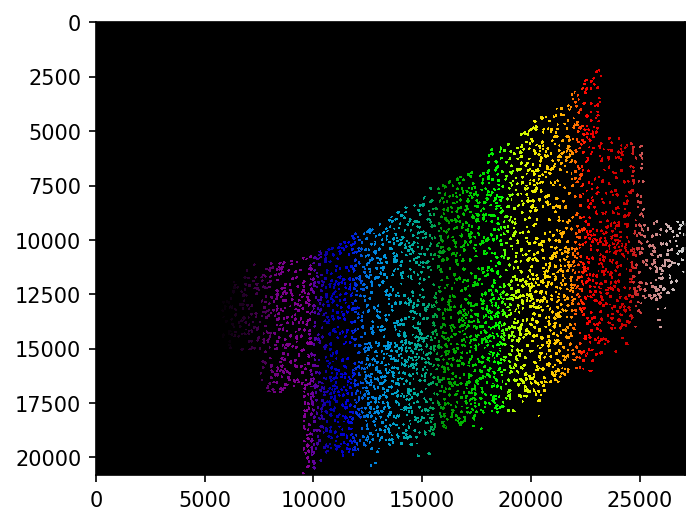

In [77]:
plt.imshow(label_image.T, cmap=plt.cm.nipy_spectral)

The `SegmentationMaskCollection` should be fine and should be usable with downstream point assignments, despite napari not working. For downstream point assignments, the coordinate negation should be eliminated from the above function. 